# Kaggle: Dog Breed Identification

[Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification) is a supervised problem that identifying 120 dog breeds using around ten thousand images with labels for training. In this implementation, you can get log loss **0.18** by setting (NUM_CLASSES=120, INPUT_SIZE=400).

# Execution Environment

Operating System: ubuntu 16.04 LTS 64-bit<br>
Central Processing Unit: Intel® Core™ i7-6700HQ CPU @ 2.60GHz × 8 <br>
Graphics Processing Units: GeForce GTX 965M/PCIe/SSE2

# Transfer learning with pretrained models

We use predictions from pretrained models as features and then take those features as input of logistic regression to solve Dog Breed Classification problem. Thank to pretrained models, we can get useful extraction bottleneck features without training a huge neural network. Because imagenet that pretrain these models also include many dog images, we can consider this solution as transfer learning with overlapping target.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm

from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications import inception_resnet_v2


/home/andy/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
NUM_CLASSES: Number of classes used in classification
INPUT_SIZE: Input images size are (INPUT_SIZE, INPUT_SIZE)
"""
NUM_CLASSES = 32
INPUT_SIZE = 350

SEED = 1993
data_dir = './Data'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))

print('train images, labels number:', len(listdir(join(data_dir, 'train'))), ',', len(labels))
print('test images, labels number:', len(listdir(join(data_dir, 'test'))), ',', len(sample_submission))

train images, labels number: 10222 , 10222
test images, labels number: 10357 , 10357


## Data Exploration
We can find the frequency of each class in figure below. Every class has at least 60 images, but the most common one are almost twice as many examples as the last common one. It is also a feasible way to consider the distribution when training the data.  

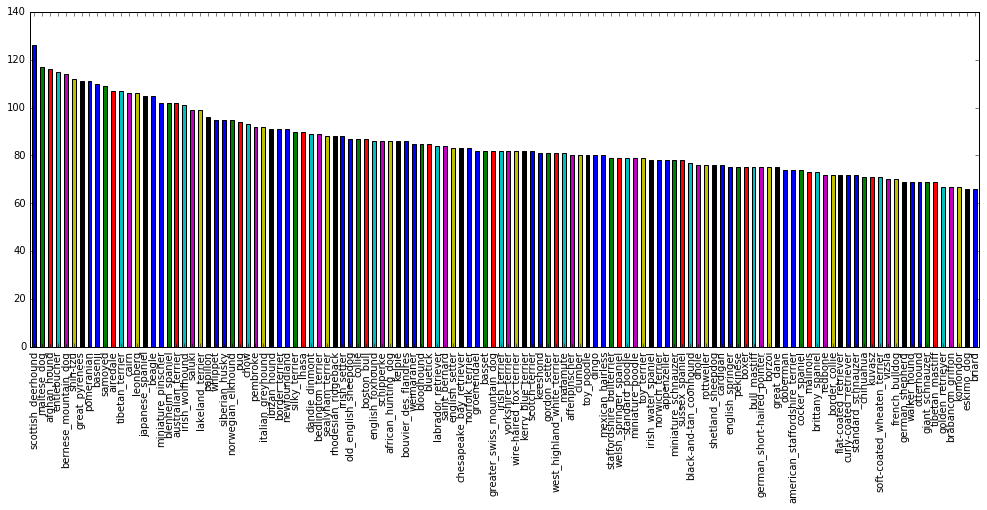

In [3]:
plt.figure(figsize=(17, 6))
labels['breed'].value_counts().plot(kind='bar')
plt.show()

## Data Preprocessing
In this implementation, I use only top 32 frequency classes due to computing resourse. You can adjust parameter NUM_CLASSES to test the performance.

**Notice**: Image input size is a important parameter in this classification because of different size of training images. You can adjust this parameter to test the performance. In my implementation, 400 seems to be a better size for the models I uesd. There are also some discussion([43203](https://www.kaggle.com/c/dog-breed-identification/discussion/43203) / [45760](https://www.kaggle.com/c/dog-breed-identification/discussion/45760)) on Kaggle.

In [30]:
# Only top NUM_CLASSES used in classification
top_breed = sorted(list(labels['breed'].value_counts().head(NUM_CLASSES).index))
train_df = labels[labels['breed'].isin(top_breed)]

# Turn labels into one-hot
target = pd.Series(train_df['breed'])
one_hot = pd.get_dummies(target, sparse=True)
one_hot_labels = np.asarray(one_hot)

# Split training and validation data 80:20
id_tr, id_v, breed_tr, breed_v = train_test_split( train_df['id'], one_hot_labels, test_size=0.2,
                                                   random_state=SEED, stratify=np.array(train_df['breed']) )

print('id_tr, id_v, breed_tr, breed_v shape:', (id_tr.shape, id_v.shape, breed_tr.shape, breed_v.shape))

id_tr, id_v, breed_tr, breed_v shape: ((2652,), (664,), (2652, 32), (664, 32))


In [28]:
def read_img(img_id, train_or_test, size):
    ''' Read and resize image
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'
        size: resize the original image
    # Returns
        Image as numpy array
    '''
    img = image.load_img(join(data_dir, train_or_test, '{}.jpg'.format(img_id)), target_size=size)
    img = image.img_to_array(img)
    return img

In [31]:
Xtr = np.zeros((id_tr.shape[0], INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
Ytr = np.zeros((breed_tr.shape[0], NUM_CLASSES), dtype='uint8')
Xv = np.zeros((id_v.shape[0], INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
Yv = np.zeros((breed_v.shape[0], NUM_CLASSES), dtype='uint8')

# Load training images/labels
for i, img_id in tqdm(enumerate(id_tr.values)):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    Xtr[i] = img
    Ytr[i] = breed_tr[i]

# Load validation images/labels
for i, img_id in tqdm(enumerate(id_v.values)):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    Xv[i] = img
    Yv[i] = breed_v[i]

print('Xtr, Xv, Ytr, Yv shape:', (Xtr.shape, Xv.shape, Ytr.shape, Yv.shape))

2652it [00:06, 437.09it/s]
664it [00:01, 442.99it/s]

Xtr, Xv, Ytr, Yv shape: ((2652, 350, 350, 3), (664, 350, 350, 3), (2652, 32), (664, 32))


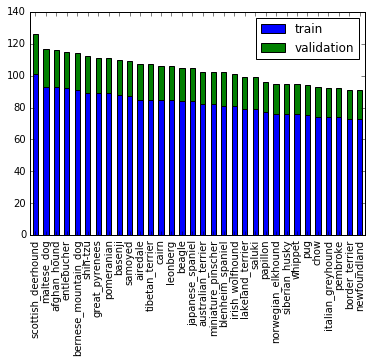

In [32]:
# plt show training and validation data balanced in each class
data = pd.Series((breed_tr*range(NUM_CLASSES)).sum(axis=1)).value_counts().sort_index().to_frame()
data.columns = ['train']
data['validation'] = pd.Series((breed_v*range(NUM_CLASSES)).sum(axis=1)).value_counts().sort_index().to_frame()
data.index = top_breed

new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)
new_plot.plot(kind='bar', stacked=True)
plt.show()

## Etract Bottleneck Features
I extract bottleneck features from pretained Xception, Inception_v3, Inception_resnet_v2 model prediction, which perform quite well on imagenet dataset. There is also a whole [pretrained model prediction comparsion](https://www.kaggle.com/c/dog-breed-identification/discussion/46201) on Kaggle discussion.

In [33]:
Models = {
    'xception': {
        'model': xception.Xception,
        'preprocess': xception.preprocess_input
    },
    'inception_v3': {
        'model': inception_v3.InceptionV3,
        'preprocess': inception_v3.preprocess_input
    },
    'inception_resnet_v2': {
        'model': inception_resnet_v2.InceptionResNetV2,
        'preprocess': inception_resnet_v2.preprocess_input
    }
}

In [34]:
batch_size = 32
input_shape = (INPUT_SIZE, INPUT_SIZE, 3)

def get_bottleneck_features(extract_model, x, y, datagen):
    ''' Extract bottleneck features from prediction by using data generator
    # Arguments 
        extract_model: model from dictionary
        x: train/test data as model input
        y: train label [no use]
        datagen: ImageDataGenerator type
    # Returns
        bottleneck features from prediction
    '''
    
    datagen.preprocessing_function = extract_model['preprocess']  
    generator = datagen.flow(x, y, shuffle=False, batch_size=batch_size, seed=SEED)    
    model = extract_model['model'](weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    
    return model.predict_generator(generator, verbose=1)

In [35]:
train_bf_ensemble=[]
valid_bf_ensemble=[]

for model_name, model in Models.items():
    
    path = './npy_data/'
    trainfilename = path + model_name + '_train_features.npy'
    validfilename = path + model_name + '_valid_features.npy'
    
    if exists(trainfilename):
        print('Loading '+ model_name +' bottleneck features...')
        
        train_bf = np.load(trainfilename)
        valid_bf = np.load(validfilename)
    else:
        print('Generating '+ model_name +' bottleneck features...')
        
        train_datagen = ImageDataGenerator(
            zoom_range = 0.4,
            width_shift_range=0.15,
            height_shift_range=0.15
        )
        valid_datagen = ImageDataGenerator()
        
        train_bf = get_bottleneck_features(model, Xtr, Ytr, train_datagen)
        valid_bf = get_bottleneck_features(model, Xv, Yv, valid_datagen)
        
        np.save(trainfilename, train_bf)
        np.save(validfilename, valid_bf)
    
    train_bf_ensemble.append(train_bf)
    valid_bf_ensemble.append(valid_bf)
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(train_bf, (Ytr * range(NUM_CLASSES)).sum(axis=1))
    
    valid_probs = logreg.predict_proba(valid_bf)
    valid_preds = logreg.predict(valid_bf)

    print(model_name + ' validation LogLoss {}'.format(log_loss(Yv, valid_probs)))
    print(model_name + ' validation Accuracy {} \n'.format(accuracy_score((Yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Generating inception_resnet_v2 bottleneck features...
21/21 [==============================] - 38s 2s/step
inception_resnet_v2 validation LogLoss 0.10635862780629854
inception_resnet_v2 validation Accuracy 0.9698795180722891 

Generating inception_v3 bottleneck features...
21/21 [==============================] - 32s 2s/step
inception_v3 validation LogLoss 0.10958658780019258
inception_v3 validation Accuracy 0.9683734939759037 

Generating xception bottleneck features...
21/21 [==============================] - 36s 2s/step
xception validation LogLoss 0.10080266677845459
xception validation Accuracy 0.9728915662650602 



# Ensemble Bottleneck Features
Take stacked bottleneck features from three models as input of logistic regression. However, if you use too few classes, performance may not improve or even worse. You can also ensemble the prediction from logistic regression by averaging, but it seems to get a higher loss. As you can see, validation loss can get **0.0776** after ensembling.

In [38]:
train_bf = np.hstack(train_bf_ensemble)
valid_bf = np.hstack(valid_bf_ensemble)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_bf, (Ytr * range(NUM_CLASSES)).sum(axis=1))

valid_probs = logreg.predict_proba(valid_bf)
valid_preds = logreg.predict(valid_bf)

print('validation LogLoss {}'.format(log_loss(Yv, valid_probs)))
print('validation Accuracy {} \n'.format(accuracy_score((Yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

validation LogLoss 0.08717258944338696
validation Accuracy 0.9713855421686747 



# Fully Connected on Ensemble Features
You can get better performance by training few fully connected layer on ensemble features. After training, validation loss can be lower than **0.074**. The improvement can be more obvious when the used class increase.

In [45]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

bf_input = Input(shape=(train_bf.shape[1], ), name='input')
dropout1 = Dropout(0.5, name='dropout_1')(bf_input)
fc_layer = Dense(2500, activation='relu', name='fc')(dropout1)
dropout2 = Dropout(0.5, name='dropout_2')(fc_layer)
prediction = Dense(Ytr.shape[1], activation='softmax', name='prediction')(dropout2)

FC_model = Model(inputs=bf_input, outputs=prediction)
FC_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5632)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
fc (Dense)                   (None, 2500)              14082500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2500)              0         
_________________________________________________________________
prediction (Dense)           (None, 32)                80032     
Total params: 14,162,532
Trainable params: 14,162,532
Non-trainable params: 0
_________________________________________________________________


In [46]:
checkpoint = ModelCheckpoint('./best_model/FC_best_model.h5', 
                             monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

FC_model.compile(loss='categorical_crossentropy', 
                 optimizer=SGD(lr=1e-3, momentum=0.9), 
                 metrics=['accuracy'])

FC_model.fit(train_bf, Ytr, epochs=50, batch_size=32, 
             validation_data=(valid_bf, Yv), callbacks=[checkpoint, earlystop])

Train on 2652 samples, validate on 664 samples
Epoch 1/50
2652/2652 [==============================] - 2s 656us/step - loss: 2.8107 - acc: 0.3537 - val_loss: 1.4903 - val_acc: 0.9443

Epoch 00001: val_loss improved from inf to 1.49034, saving model to ./best_model/FC_best_model.h5
Epoch 2/50
2652/2652 [==============================] - 1s 555us/step - loss: 1.1700 - acc: 0.8797 - val_loss: 0.4043 - val_acc: 0.9669

Epoch 00002: val_loss improved from 1.49034 to 0.40433, saving model to ./best_model/FC_best_model.h5
Epoch 3/50
2652/2652 [==============================] - 1s 536us/step - loss: 0.5256 - acc: 0.9351 - val_loss: 0.1908 - val_acc: 0.9684

Epoch 00003: val_loss improved from 0.40433 to 0.19079, saving model to ./best_model/FC_best_model.h5
Epoch 4/50
2652/2652 [==============================] - 1s 562us/step - loss: 0.3276 - acc: 0.9495 - val_loss: 0.1332 - val_acc: 0.9744

Epoch 00004: val_loss improved from 0.19079 to 0.13318, saving model to ./best_model/FC_best_model.h5
E

# Check Error
We can go through the wrong classified image to see what's wrong with our classification.

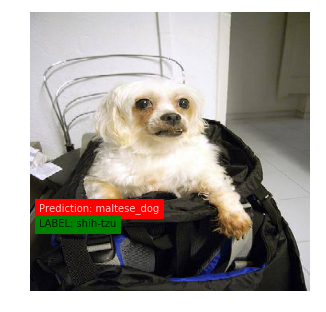

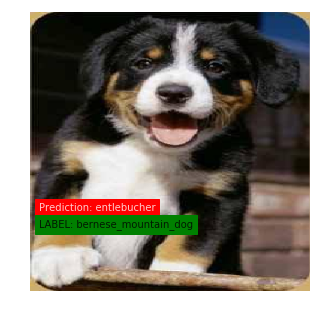

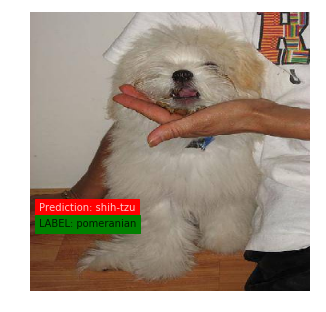

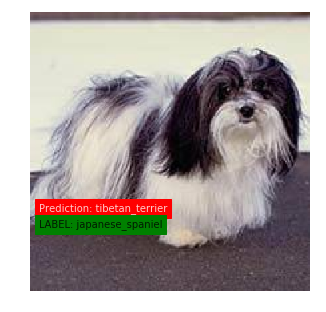

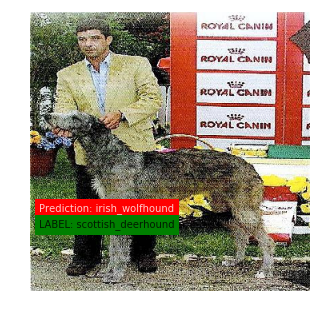

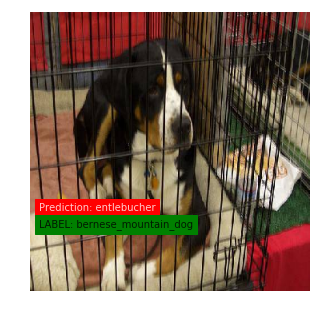

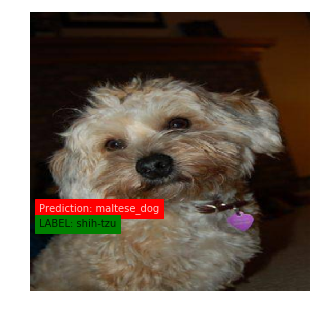

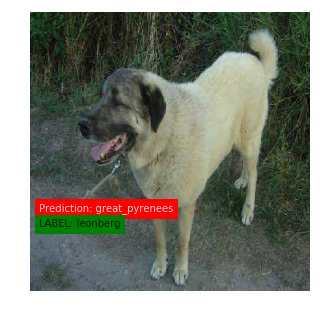

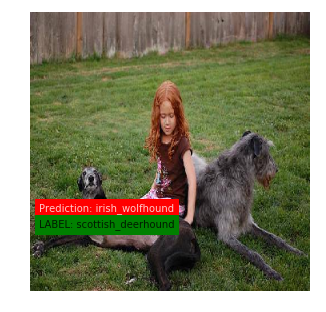

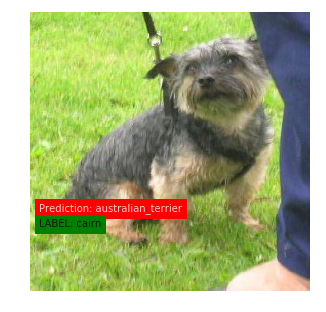

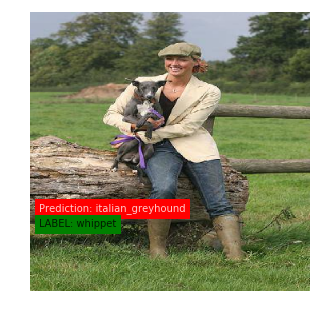

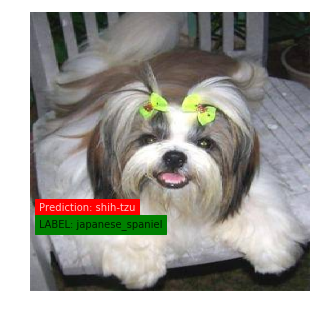

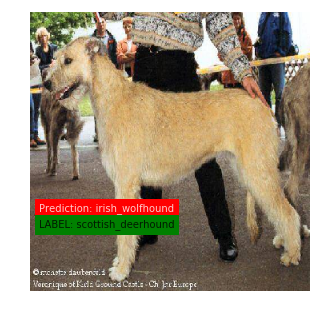

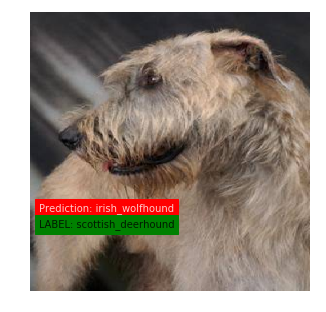

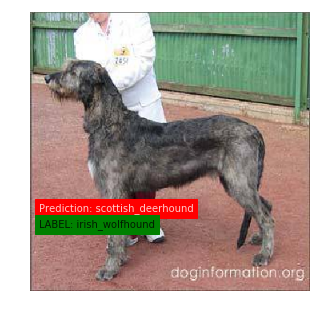

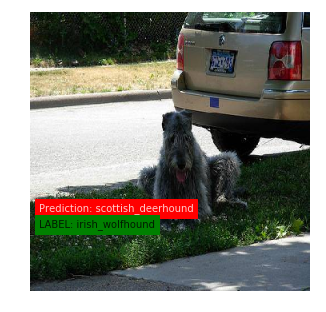

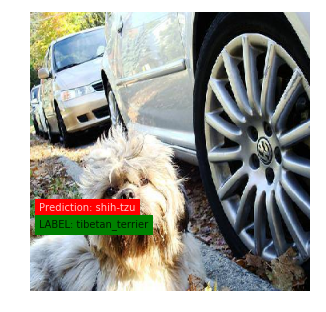

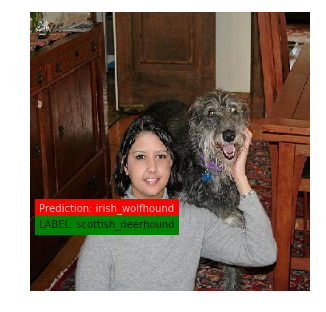

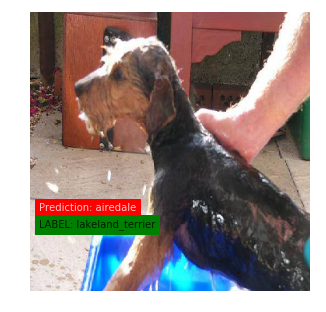

In [45]:
valid_breeds = (Yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)

for img_id, breed, breed_pred in zip(id_v.values[error_idx],
                                     [top_breed[x] for x in (Yv*range(NUM_CLASSES)).sum(axis=1)[error_idx]],
                                     [top_breed[x] for x in valid_preds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (INPUT_SIZE,INPUT_SIZE))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: {}'.format(breed_pred), color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: {}'.format(breed), color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()    